In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler

!pip install --upgrade category_encoders
import category_encoders as ce
from sklearn.metrics import classification_report, roc_auc_score
from time import time
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from collections import Counter
from sklearn.model_selection import train_test_split
import warnings
import re
import torch
from nltk.stem.porter import PorterStemmer
from pandas.testing import assert_frame_equal
from pandas import testing as tm


# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Mounted at /content/drive/
     |████████████████████████████████| 86 kB 3.7 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


'Tesla P100-PCIE-16GB'

In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:

%pwd


'/content'

## STEPS FOLLOWED

- Load latest data: songs_charts_final.csv
- Rename columns (added suffix '_n') to avoid conflicts when TF-IDF vectorized column names same as original column names
- Split train,validation,test data including oversampling for balancing
- TFIDF Vectorization of Train data
-------tokenize lyrics column (removed punctuations, stop words,      lemmetization, stemming as part of pre-processing)
-------Convert the tokenized train data into a dataframe
-------Concatenate the tokenization dataframe to the orignal one(reset index).-------dropping columns not feeding into final models to create main train and test frames
- Repeated same steps as above for TFIDF Vectorization of test data
- Created train data (X_train), train lables, test data (X_test), test labels from these frames
- Label encoding on metadata multi-categorical features (as not numeric, majority ordinal and multiple categories and unable to feed into models) for both test and train sets
- Run multinomial NB model and evaluate
- Run Logistic Regression model and evaluate

## **Load Data**

In [3]:
data = pd.read_csv("~/w266_project_topmusichits/data/processed/songs_charts_final.csv")
print(data.columns)
print("Length of data:",len(data))

Index(['song_year', 'song_name', 'artist_name', 'album_name', 'genre',
       'lyrics', 'danceability', 'loudness', 'speechiness', 'acousticness',
       'valence', 'tempo', 'num_nonlexvoc', 'star', 'hit'],
      dtype='object')
Length of data: 8546


In [4]:
# Visualize data
data.head()


,song_year,song_name,artist_name,album_name,genre,lyrics,danceability,loudness,speechiness,acousticness,valence,tempo,num_nonlexvoc,star,hit
0,2000,Tho Dem Wraps,Nelly,Country Grammar,rap,"I boss thru in a Hummer, Murphy the Don, Lizzi...",medium,medium,medium,low,medium,high,low,no,0
1,2000,Beautiful Day,U2,All That You Can't Leave Behind,rock,"The heart is a bloom, shoots up through the st...",low,medium,medium,low,medium,high,low,yes,1
2,2000,Kryptonite,3 Doors Down,The Better Life,rock,"Well, I took a walk around the world to ease m...",low,medium,low,low,medium,low,low,no,1
3,2000,Without You,Lucy Pearl,Lucy Pearl,r&b,Girl you know I want you And I dont know what ...,high,high,high,high,high,low,low,yes,0
4,2000,Ride Wit Me,Nelly,Country Grammar,rap,Where they at? Where they at? Where they at? W...,high,medium,medium,medium,high,low,high,yes,1


In [5]:
data.columns

Index(['song_year', 'song_name', 'artist_name', 'album_name', 'genre',
       'lyrics', 'danceability', 'loudness', 'speechiness', 'acousticness',
       'valence', 'tempo', 'num_nonlexvoc', 'star', 'hit'],
      dtype='object')

In [6]:
#Renaming columns to avoid conflict when TF-IDF vectors fetch names gets column names which can be same as existing gcolumns
data.rename(columns = {'genre':'genre_n', 'lyrics':'lyrics_n','danceability':'danceability_n',
                       'loudness':'loudness_n','speechiness':'speechniess_n','acousticness': 'accousticness_n',
                       'valence':'valence_n', 'tempo':'tempo_n', 'star': 'star_n', 'hit':'hit_n'}, inplace = True)
data.columns

Index(['song_year', 'song_name', 'artist_name', 'album_name', 'genre_n',
       'lyrics_n', 'danceability_n', 'loudness_n', 'speechniess_n',
       'accousticness_n', 'valence_n', 'tempo_n', 'num_nonlexvoc', 'star_n',
       'hit_n'],
      dtype='object')

In [7]:
# Define cutoff date and split train, validation and test sets
split_year = 2017
train_df = data[data['song_year'] < split_year]
test_df = data[data['song_year'] >= split_year]

# Take sample of data FOR TESTING PURPOSES if desired (COMMENT OUT FOR WHOLE DATASET)
# train_df= train_df.iloc[0:100]
# test_df = test_df.iloc[0:50]

# Define features and target
X = train_df.drop(['hit_n'], axis=1)  #keep only the columns that we will use as x's. Right now I am only removing the y from it but we need to remove all the useless columns
y = train_df['hit_n']

# Split  training data into training and validation sets (70% - 30%)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42) #Random state is to get reproducible results


# Oversample hits in dataset to have a 3:2 balance of non-hits vs hits
oversample = RandomOverSampler(sampling_strategy=2/3)
X_train_over, y_train_over = oversample.fit_resample(X_train, y_train)
X_val_over, y_val_over = oversample.fit_resample(X_val, y_val)

# Recombine the features and target datasets
train_df_over = pd.concat([X_train_over.reset_index(drop=True), y_train_over.reset_index(drop=True)],axis=1)
val_df_over = pd.concat([X_val_over.reset_index(drop=True), y_val_over.reset_index(drop=True)],axis=1)

In [8]:
#printing original dimensions to refer back to when merginf TF-IDF frame
#test_df['hit'].value_counts()
print(train_df_over.shape)
print(val_df_over.shape)
print(test_df.shape)

(4411, 15)
(1910, 15)
(3632, 15)


In [9]:
# https://tartarus.org/martin/PorterStemmer/def.txt
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

porter_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stopwords = stopwords.words('english') #remove stopwords
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split() #remove punctuation, lowercase things and split them on spaces
    words = [porter_stemmer.stem(word) for word in words if word not in stopwords] #removes stopwords and stemming
    words = [lemmatizer.lemmatize(word) for word in words] # lemmatization
    return words


#EXAMPLE TO TEST
stemming_tokenizer('This is a 45 degree an@gle and good greatest heights audible sound enjoyable better, experience 12, corpora #!')
#lemmatizer.lemmatize('better')

#resource: https://jonathansoma.com/lede/foundations/classes/text%20processing/tf-idf/


['45',
 'degre',
 'gle',
 'good',
 'greatest',
 'height',
 'audibl',
 'sound',
 'enjoy',
 'better',
 'experi',
 '12',
 'corpus']

In [10]:
##TF-IDF Vectorizer on lyrics removing stopwords

#tokenize text column
v = TfidfVectorizer(tokenizer=stemming_tokenizer)
x = v.fit_transform(train_df_over['lyrics_n'])
x_tftest = v.transform(test_df['lyrics_n'])

#Convert the tokenized train data into a dataframe
df1 = pd.DataFrame(x.toarray(), columns=v.get_feature_names_out())

#Concatenate the tokenization dataframe to the orignal one:
res = pd.concat([train_df_over.reset_index(drop=True), df1.reset_index(drop=True)], axis=1)

#dropping columns not feeding into final models
res1 = res.drop(['song_year', 'song_name', 'artist_name', 'album_name', 'lyrics_n'], axis=1)

#check if the two frames merged have the same index
a = train_df_over.index
b = res1.index
tm.assert_index_equal(a,b)

#check
res1.head(7)

#resource: https://stackoverflow.com/questions/45961747/append-tfidf-to-pandas-dataframe

,genre_n,danceability_n,loudness_n,speechniess_n,accousticness_n,valence_n,tempo_n,num_nonlexvoc,star_n,hit_n,...,zorn,zu,zucchini,zuckerberg,zuli,zulu,zumba,zute,zz,zzz
0,rap,medium,high,high,high,low,high,low,yes,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,latin,high,high,medium,low,medium,high,high,yes,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,r&b,high,high,high,high,high,medium,low,no,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,rock,medium,low,low,medium,high,medium,low,yes,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,pop,high,high,medium,low,high,medium,low,no,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,rock,low,medium,low,high,high,medium,low,no,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,latin,high,high,high,high,high,low,medium,yes,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
#similar as above on test data

#Convert the tokenized test data into a dataframe
df2 = pd.DataFrame(x_tftest .toarray(), columns=v.get_feature_names_out())

#Concatenate the tokenization dataframe to the orignal one:
res_test = pd.concat([test_df.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)

#dropping columns not feeding into final models
res2 = res_test.drop(['song_year', 'song_name', 'artist_name', 'album_name', 'lyrics_n'], axis=1)

#check
res2.head(6)


,genre_n,danceability_n,loudness_n,speechniess_n,accousticness_n,valence_n,tempo_n,num_nonlexvoc,star_n,hit_n,...,zorn,zu,zucchini,zuckerberg,zuli,zulu,zumba,zute,zz,zzz
0,r&b,medium,medium,medium,high,high,low,low,no,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rock,low,medium,medium,low,medium,high,low,yes,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rap,medium,medium,low,low,low,high,low,no,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,r&b,medium,medium,high,high,high,low,low,no,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,r&b,low,low,high,high,medium,medium,medium,yes,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,rap,low,medium,high,low,high,low,low,yes,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
#Creating train data, train lables
res1_train = res1.drop(['hit_n'], axis=1)
res1_trainlabel = res1['hit_n']
res1_train.head()

# Creating test data, test labels
res2_test = res2.drop(['hit_n'], axis=1)
res2_testlabel = res2['hit_n']
res2_test.head()

,genre_n,danceability_n,loudness_n,speechniess_n,accousticness_n,valence_n,tempo_n,num_nonlexvoc,star_n,-,...,zorn,zu,zucchini,zuckerberg,zuli,zulu,zumba,zute,zz,zzz
0,r&b,medium,medium,medium,high,high,low,low,no,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,rock,low,medium,medium,low,medium,high,low,yes,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,rap,medium,medium,low,low,low,high,low,no,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,r&b,medium,medium,high,high,high,low,low,no,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,r&b,low,low,high,high,medium,medium,medium,yes,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Most of our metadata were ordinal features classified as low medium high we decided to use label encoding to reduce the number of dimensions we would have 
#with one hot encoding
#label encoding
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

# Instantiate LabelEncoder

le = LabelEncoder()


cols=['genre_n', 'danceability_n', 'loudness_n', 'speechniess_n','accousticness_n', 'valence_n', 'tempo_n', 'num_nonlexvoc', 'star_n' ]

res1_train[cols] = res1_train[cols].apply(LabelEncoder().fit_transform)
res2_test[cols] = res2_test[cols].apply(LabelEncoder().fit_transform)



res1_train.head(5)
res2_test.head(5)

#resource: https://vitalflux.com/labelencoder-example-single-multiple-columns/

,genre_n,danceability_n,loudness_n,speechniess_n,accousticness_n,valence_n,tempo_n,num_nonlexvoc,star_n,-,...,zorn,zu,zucchini,zuckerberg,zuli,zulu,zumba,zute,zz,zzz
0,2,2,2,2,0,0,1,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,1,2,2,1,2,0,1,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,2,2,1,1,1,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,2,2,0,0,0,1,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,1,1,0,0,2,2,2,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X_train = res1_train #rename to X_train
X_test = res2_test #rename to X_test 

ROC AUC score for oversampled data:  0.5080411852848138
Accuracy of NAIVE BAYES on test set:   0.865
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      3145
           1       0.42      0.02      0.04       487

    accuracy                           0.86      3632
   macro avg       0.64      0.51      0.48      3632
weighted avg       0.81      0.86      0.81      3632

------------------------------


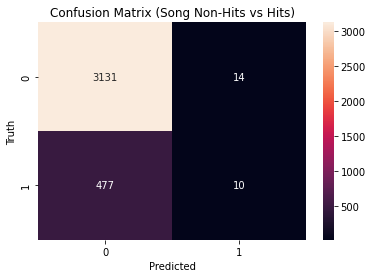

In [29]:
# NAIVE BAYES WITH METADATA

model = MultinomialNB()

clf = model.fit(X_train, res1['hit_n'])
pred = clf.predict(X_test)

print("ROC AUC score for oversampled data: ", roc_auc_score(res2['hit_n'], pred))

# compute the performance measures
score1 = metrics.accuracy_score(res2['hit_n'], pred)
print("Accuracy of NAIVE BAYES on test set:   %0.3f" % score1)

print(metrics.classification_report(res2['hit_n'], pred))

cm = metrics.confusion_matrix(res2['hit_n'], pred)
sn.heatmap(cm,annot=True,fmt='d')
plt.title("Confusion Matrix (Song Non-Hits vs Hits)")
plt.xlabel("Predicted")
plt.ylabel('Truth')

print('------------------------------')

# NB WITHOUT METADATA

In [30]:
#dropping metadata columns not feeding into final models
X_train = res1_train.drop(['genre_n',	'danceability_n',	'loudness_n',	'speechniess_n',	'accousticness_n',	'valence_n',	'tempo_n',	'num_nonlexvoc'	,'star_n'], axis=1)
#dropping metadata columns not feeding into final models
X_test = res2_test.drop(['genre_n',	'danceability_n',	'loudness_n',	'speechniess_n',	'accousticness_n',	'valence_n',	'tempo_n',	'num_nonlexvoc'	,'star_n'], axis=1)


ROC AUC score for oversampled data:  0.5134390822758983
Accuracy of NAIVE BAYES on test set:   0.855
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3145
           1       0.26      0.05      0.08       487

    accuracy                           0.85      3632
   macro avg       0.57      0.51      0.50      3632
weighted avg       0.79      0.85      0.81      3632

------------------------------


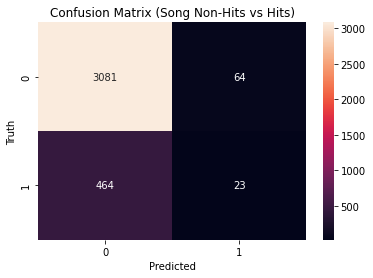

In [31]:
# NAIVE BAYES WITHOUT METADATA

model = MultinomialNB()

clf = model.fit(X_train, res1['hit_n'])
pred = clf.predict(X_test)

print("ROC AUC score for oversampled data: ", roc_auc_score(res2['hit_n'], pred))

# compute the performance measures
score1 = metrics.accuracy_score(res2['hit_n'], pred)
print("Accuracy of NAIVE BAYES on test set:   %0.3f" % score1)

print(metrics.classification_report(res2['hit_n'], pred))

cm = metrics.confusion_matrix(res2['hit_n'], pred)
sn.heatmap(cm,annot=True,fmt='d')
plt.title("Confusion Matrix (Song Non-Hits vs Hits)")
plt.xlabel("Predicted")
plt.ylabel('Truth')

print('------------------------------')